# K-means Clustering

In [1]:
# Import Findsparkd
import findspark
findspark.init()
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col, asc,desc
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [2]:
spark=SparkSession.builder \
.master ("local[*]")\
.appName("week3")\
.getOrCreate()
sc=spark.sparkContext
sqlContext=SQLContext(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/27 16:10:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/27 16:10:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


/Users/nathanzlomke/Documents/spark-3.3.3-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

In [4]:
top10_data = spark.read.parquet('/Users/nathanzlomke/Downloads/output_wTarget')
top10df = top10_data.toPandas()
top10df.head()


,Duration,nr_employed,euribor3m,cons_conf_idx,age,cons_price_idx,education_OHE,housing_OHE,emp_var_rate,campaign,y
0,261,5191.0,4.857,-36.4,56,93.994,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no
1,149,5191.0,4.857,-36.4,57,93.994,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no
2,226,5191.0,4.857,-36.4,37,93.994,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",1.1,1,no
3,151,5191.0,4.857,-36.4,40,93.994,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no
4,307,5191.0,4.857,-36.4,56,93.994,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no


In [5]:
feature_cols = top10_data.columns[:-1]
feature_cols

['Duration',
 'nr_employed',
 'euribor3m',
 'cons_conf_idx',
 'age',
 'cons_price_idx',
 'education_OHE',
 'housing_OHE',
 'emp_var_rate',
 'campaign']

In [6]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
top10_assembled = assembler.transform(top10_data)

Silhouette with squared euclidean distance for k=5: 0.6150213850484735
+----------+
|prediction|
+----------+
|         1|
|         0|
|         1|
|         0|
|         1|
|         0|
|         0|
|         1|
|         1|
|         0|
|         0|
|         1|
|         0|
|         1|
|         0|
|         0|
|         1|
|         1|
|         1|
|         0|
+----------+
only showing top 20 rows



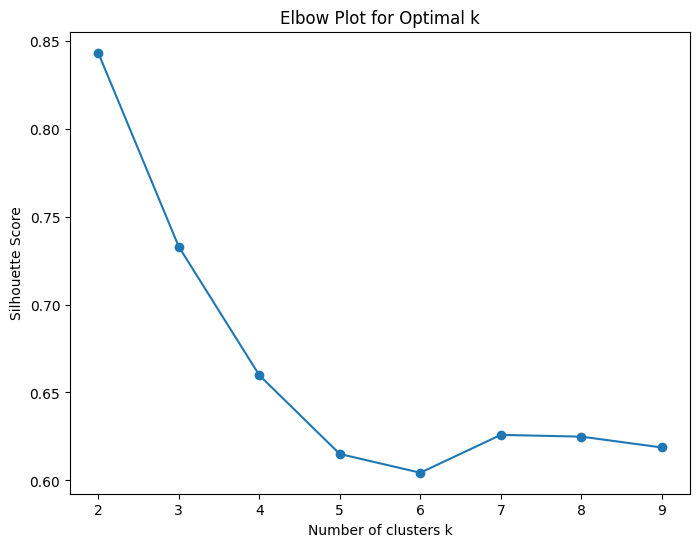

In [7]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator_Kmeans = ClusteringEvaluator()

silhouette_scores = []
k_range = range(2, 10)  # Example range, can be adjusted

for k_find in k_range:
    kmeans = KMeans(k=k_find, predictionCol='prediction').setSeed(12345)
    model = kmeans.fit(top10_assembled)
    predictions_Kmeans = model.transform(top10_assembled)
    silhouette = evaluator_Kmeans.evaluate(predictions_Kmeans)
    silhouette_scores.append(silhouette)

    if k_find == 5:  # If k is 5, print the silhouette score and display the result
        print("Silhouette with squared euclidean distance for k=5: " + str(silhouette))
        predictions_Kmeans.select('prediction').show()

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot for Optimal k')
plt.show()


In [8]:
# Assume you want to create 5 clusters
kmeans = KMeans(featuresCol='features', k=5)
model = kmeans.fit(top10_assembled)
predictions_Kmeans = model.transform(top10_assembled
                                     )
silhouette = evaluator_Kmeans.evaluate(predictions_Kmeans)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Display the result
predictions_Kmeans.select('prediction').show()

Silhouette with squared euclidean distance = 0.608056769137716
+----------+
|prediction|
+----------+
|         4|
|         0|
|         4|
|         0|
|         4|
|         0|
|         0|
|         4|
|         4|
|         0|
|         0|
|         4|
|         0|
|         4|
|         0|
|         0|
|         4|
|         4|
|         4|
|         0|
+----------+
only showing top 20 rows



### Add in target variable for post clustering analysis

In [9]:
predictions_Kmeans = predictions_Kmeans\
    .withColumnRenamed('y', 'target_yes')

predictions_Kmeansdf = predictions_Kmeans.replace(['yes', 'no'], ['1', '0'], subset='target_yes')
predictions_Kmeansdf.toPandas().head(2)


,Duration,nr_employed,euribor3m,cons_conf_idx,age,cons_price_idx,education_OHE,housing_OHE,emp_var_rate,campaign,target_yes,features,prediction
0,261,5191.0,4.857,-36.4,56,93.994,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,0,"(261.0, 5191.0, 4.857, -36.4, 56.0, 93.994, 0....",4
1,149,5191.0,4.857,-36.4,57,93.994,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,0,"(149.0, 5191.0, 4.857, -36.4, 57.0, 93.994, 0....",0


In [10]:
print(predictions_Kmeansdf.select('target_yes').dtypes)
predictions_Kmeansdf = predictions_Kmeansdf.withColumn('target_yes', predictions_Kmeansdf['target_yes'].cast(IntegerType()))

[('target_yes', 'string')]


### Cluster Means (only works for numerical features)

In [11]:
cluster_means = predictions_Kmeansdf.select(['prediction'] + feature_cols + ['target_yes']).groupBy('prediction').mean().orderBy(['prediction'])
cluster_profiles = cluster_means.toPandas()
cluster_profiles

,prediction,avg(prediction),avg(Duration),avg(nr_employed),avg(euribor3m),avg(cons_conf_idx),avg(age),avg(cons_price_idx),avg(emp_var_rate),avg(campaign),avg(target_yes)
0,0,0.0,111.181132,5175.880618,3.798616,-40.438250,39.999309,93.586236,0.225139,2.787364,0.027319
1,1,1.0,1101.886263,5169.266913,3.659376,-40.804948,39.519202,93.601082,0.133383,2.575332,0.589365
2,2,2.0,602.117315,5162.161935,3.523506,-40.740823,40.301763,93.580932,0.013246,2.332052,0.321881
3,3,3.0,2157.875000,5168.919118,3.729728,-40.456618,40.352941,93.604809,0.130882,2.176471,0.610294
4,4,4.0,298.510535,5151.613691,3.312068,-40.505412,40.022722,93.550329,-0.173593,2.236470,0.140626


### Cluster Modes (for categorical features)

There is not a implicit mode funciton in pyspark for our categorical variables, education_OHE and housing_OHE.  
Thus, we have to manually find the mode.  Best way I know to do this is to split the vectorized columns to <br>individual column assignments and find the highest frequency for each feature.<br><br>
In the end, this will be merged to the output summary dataframe for the clustering

`education_OHE`

In [12]:
from pyspark.sql.types import StructType, StructField, FloatType

num_edu_categories = 8
edu = predictions_Kmeans.select('education_OHE', 'prediction')

edu_columns = [f"edu_cat_{i + 1}" for i in range(num_edu_categories)]

# Collect the rows from the original DataFrame
edu_rows = [tuple(map(float, row["education_OHE"])) + (float(row["prediction"]),) for row in edu.collect()]

# Define the schema for the new DataFrame
schema_columns = [StructField(col_name, FloatType(), True) for col_name in edu_columns]
schema_columns.append(StructField("prediction", FloatType(), True))
schema = StructType(schema_columns)

# Create the DataFrame with the specified schema
edu_sliced = spark.createDataFrame(edu_rows, schema=schema)

# Show the sliced DataFrame
edu_sliced.toPandas().head(2)


,edu_cat_1,edu_cat_2,edu_cat_3,edu_cat_4,edu_cat_5,edu_cat_6,edu_cat_7,edu_cat_8,prediction
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
edu_sums = edu_sliced.groupBy('prediction').agg(*[F.sum(col).alias(f"{col}_sum") for col in edu_sliced.columns]).orderBy('prediction')
edu_sums.toPandas().head()

,prediction,edu_cat_1_sum,edu_cat_2_sum,edu_cat_3_sum,edu_cat_4_sum,edu_cat_5_sum,edu_cat_6_sum,edu_cat_7_sum,edu_cat_8_sum,prediction_sum
0,0.0,7012.0,5298.0,3340.0,3024.0,2280.0,1284.0,921.0,12.0,0.0
1,1.0,393.0,332.0,208.0,148.0,123.0,89.0,60.0,1.0,1354.0
2,2.0,1223.0,1023.0,672.0,553.0,517.0,232.0,201.0,3.0,8848.0
3,3.0,40.0,31.0,17.0,20.0,17.0,9.0,2.0,0.0,408.0
4,4.0,3500.0,2831.0,1808.0,1498.0,1239.0,678.0,547.0,2.0,48412.0


#### Rename education columns with original labels
Recall that OHE orders them in descending order, so we can reference the descriptive stats in the original jupyter notebook<br>
Here's a snippet:<br>
`9	education	8	university.degree	[(university.degree, 12168), (high.school, 9515), (basic.9y, 6045), (professional.course, 5243), (basic.4y, 4176), (basic.6y, 2292), (unknown, 1731), (illiterate, 18)]`

In [14]:
# Define the new column names
old_edu_names = ['edu_cat_1_sum', 'edu_cat_2_sum','edu_cat_3_sum','edu_cat_4_sum','edu_cat_5_sum','edu_cat_6_sum','edu_cat_7_sum','edu_cat_8_sum']
new_edu_names = ["university_degree", "high_school", "basic_9y", "professional_course", "basic_4y", "basic_6y", "unknown", "illiterate"]

# Use select and alias to rename columns
edu_sums = edu_sums\
    .withColumnRenamed(old_edu_names[0], new_edu_names[0])\
    .withColumnRenamed(old_edu_names[1], new_edu_names[1])\
    .withColumnRenamed(old_edu_names[2], new_edu_names[2])\
    .withColumnRenamed(old_edu_names[3], new_edu_names[3])\
    .withColumnRenamed(old_edu_names[4], new_edu_names[4])\
    .withColumnRenamed(old_edu_names[5], new_edu_names[5])\
    .withColumnRenamed(old_edu_names[6], new_edu_names[6])\
    .withColumnRenamed(old_edu_names[7], new_edu_names[7])

In [15]:
edu_sums = edu_sums.select(['prediction']+new_edu_names)
edu_sums.toPandas().head()

,prediction,university_degree,high_school,basic_9y,professional_course,basic_4y,basic_6y,unknown,illiterate
0,0.0,7012.0,5298.0,3340.0,3024.0,2280.0,1284.0,921.0,12.0
1,1.0,393.0,332.0,208.0,148.0,123.0,89.0,60.0,1.0
2,2.0,1223.0,1023.0,672.0,553.0,517.0,232.0,201.0,3.0
3,3.0,40.0,31.0,17.0,20.0,17.0,9.0,2.0,0.0
4,4.0,3500.0,2831.0,1808.0,1498.0,1239.0,678.0,547.0,2.0


In [16]:
edu_column_sums = edu_sums.agg({new_edu_names[i]: "sum" for i in range(len(new_edu_names))})
edu_column_sums.toPandas().head()

,sum(basic_9y),sum(high_school),sum(basic_6y),sum(unknown),sum(basic_4y),sum(professional_course),sum(university_degree),sum(illiterate)
0,6045.0,9515.0,2292.0,1731.0,4176.0,5243.0,12168.0,18.0


`(university.degree, 12168), (high.school, 9515), (basic.9y, 6045), (professional.course, 5243), (basic.4y, 4176), (basic.6y, 2292), (unknown, 1731), (illiterate, 18)`

Summed totals all match up to original set

In [17]:
education_mode_data = [(0, 'university_degree'), (1, 'university_degree'), (2, 'university_degree'), (3, 'university_degree'), (4, 'university_degree')]
schema = ["prediction", "education"]
education_mode = spark.createDataFrame(education_mode_data, schema=schema)
education_mode.show()

+----------+-----------------+
|prediction|        education|
+----------+-----------------+
|         0|university_degree|
|         1|university_degree|
|         2|university_degree|
|         3|university_degree|
|         4|university_degree|
+----------+-----------------+



`housing_OHE`

In [18]:
num_house_categories = 3
house = predictions_Kmeans.select('housing_OHE', 'prediction')

# Assuming edu_columns is already defined
house_columns = [f"housing_cat_{i + 1}" for i in range(num_house_categories)]# Select individual elements from the vector

# Collect the rows from the original DataFrame
house_rows = [tuple(list(map(float, row["housing_OHE"])) + [float(row['prediction'])]) for row in house.collect()]

# Define the schema for the new DataFrame
schema_columns = [StructField(col_name, FloatType(), True) for col_name in house_columns]
schema_columns.append(StructField("prediction", FloatType(), True))
schema = StructType(schema_columns)

# Create the DataFrame with the specified schema
house_sliced = spark.createDataFrame(house_rows, schema=schema)

# Show the sliced DataFrame
house_sliced.toPandas().head(2)


,housing_cat_1,housing_cat_2,housing_cat_3,prediction
0,0.0,1.0,0.0,4.0
1,0.0,1.0,0.0,0.0


In [19]:
house_sums = house_sliced.groupBy('prediction').agg(*[F.sum(col) for col in house_sliced.columns]).orderBy('prediction')
house_sums.toPandas().head()

,prediction,sum(housing_cat_1),sum(housing_cat_2),sum(housing_cat_3),sum(prediction)
0,0.0,12137.0,10450.0,584.0,0.0
1,1.0,684.0,638.0,32.0,1354.0
2,2.0,2262.0,2062.0,100.0,8848.0
3,3.0,75.0,60.0,1.0,408.0
4,4.0,6418.0,5412.0,273.0,48412.0


#### Rename housing columns with original labels
Recall that OHE orders them in descending order, so we can reference the descriptive stats in the original jupyter notebook<br>
Here's a snippet:<br>
`4	housing	3	yes	[(yes, 21576), (no, 18622), (unknown, 990)]`

In [20]:
old_house_names = ["sum(housing_cat_1)","sum(housing_cat_2)","sum(housing_cat_3)"]
new_house_names = ['yes','no','unknown']

house_sums = house_sums\
    .withColumnRenamed(old_house_names[0], new_house_names[0])\
    .withColumnRenamed(old_house_names[1], new_house_names[1])\
    .withColumnRenamed(old_house_names[2], new_house_names[2])

In [21]:
house_column_sums = house_sums.agg({new_house_names[i]: "sum" for i in range(len(new_house_names))})
house_column_sums.toPandas().head()

,sum(no),sum(yes),sum(unknown)
0,18622.0,21576.0,990.0


Summed totals all match up to original set

In [22]:
house_sums = house_sums.select('prediction','yes','no','unknown')
house_sums.toPandas().head()
housing_mode_data = [(0, 'yes'), (1, 'yes'), (2, 'yes'), (3, 'yes'), (4, 'yes')]
schema = ["prediction", "housing"]
housing_mode = spark.createDataFrame(housing_mode_data, schema=schema)
housing_mode.show()


+----------+-------+
|prediction|housing|
+----------+-------+
|         0|    yes|
|         1|    yes|
|         2|    yes|
|         3|    yes|
|         4|    yes|
+----------+-------+



#### Join the Mean (numeric) columns with the Mode (categorical) columns into one dataframe

In [23]:
housing_mode = housing_mode.toPandas()
all_cluster_profiles = cluster_profiles.merge(housing_mode, on='prediction', suffixes=('', '_housing'))
education_mode = education_mode.toPandas()
all_cluster_profiles = all_cluster_profiles.merge(education_mode, on='prediction', suffixes=('','_housing'))
all_cluster_profiles


,prediction,avg(prediction),avg(Duration),avg(nr_employed),avg(euribor3m),avg(cons_conf_idx),avg(age),avg(cons_price_idx),avg(emp_var_rate),avg(campaign),avg(target_yes),housing,education
0,0,0.0,111.181132,5175.880618,3.798616,-40.438250,39.999309,93.586236,0.225139,2.787364,0.027319,yes,university_degree
1,1,1.0,1101.886263,5169.266913,3.659376,-40.804948,39.519202,93.601082,0.133383,2.575332,0.589365,yes,university_degree
2,2,2.0,602.117315,5162.161935,3.523506,-40.740823,40.301763,93.580932,0.013246,2.332052,0.321881,yes,university_degree
3,3,3.0,2157.875000,5168.919118,3.729728,-40.456618,40.352941,93.604809,0.130882,2.176471,0.610294,yes,university_degree
4,4,4.0,298.510535,5151.613691,3.312068,-40.505412,40.022722,93.550329,-0.173593,2.236470,0.140626,yes,university_degree


#### Export to csv for conditional formatting in Excel

In [24]:
all_cluster_profiles.drop(columns='avg(prediction)', inplace=True)

In [25]:
all_cluster_profiles.to_csv('/Users/nathanzlomke/Downloads/cluster_profiles.csv', index=False)

## Visualization using PCA

In [29]:
#PCA shouldn't be necessary unless wanting to plot the clusters in a 2-dimensional feature space

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Assuming your features are in columns "feature1", "feature2", ..., "feature10"
feature_cols = predictions_Kmeans.columns

# Assemble features into a single vector column
#vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
#top10_assembled = vector_assembler.transform(top10)

# Apply PCA
pca = PCA(k=2, inputCol='features', outputCol="pca_features")
pca_model = pca.fit(predictions_Kmeans)
pca_result = pca_model.transform(predictions_Kmeans)


<Figure size 800x600 with 0 Axes>

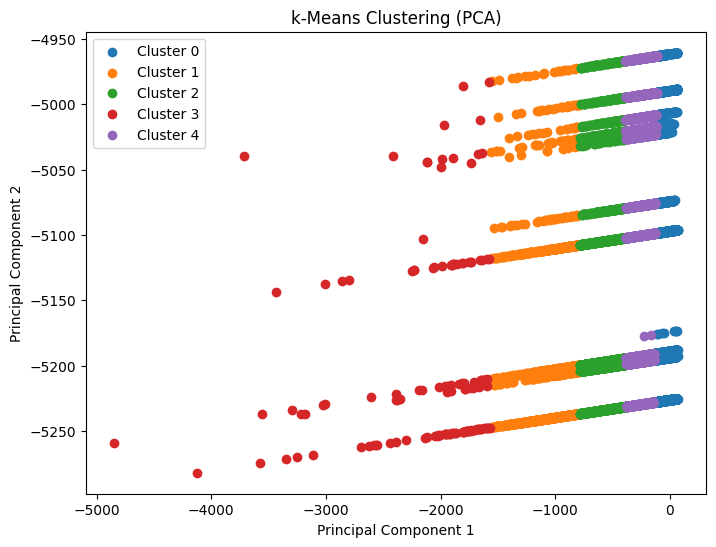

In [31]:

# Visualize the clusters
pca_predictions_pd = pca_result.select("prediction", "pca_features").toPandas()
k=5
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
for cluster_id in range(k):
    cluster_data = pca_predictions_pd[pca_predictions_pd["prediction"] == cluster_id]
    plt.scatter(cluster_data["pca_features"].apply(lambda x: x[0]), cluster_data["pca_features"].apply(lambda x: x[1]), label=f"Cluster {cluster_id}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("k-Means Clustering (PCA)")
plt.legend()
plt.show()

